#### Series de Tiempo (EVI y NDVI)
**Autor:** Javier Martínez

**Tutor:** Isabel LLatas

Los datos [*MODIS/006/MOD13Q1*](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1) del catálogo GEE corresponden al producto *MOD13Q1.v006* de la NASA. Este proporciona el valor del índice de vegetación por píxel para el EVI y NDVI. Vale destacar que el algoritmo diseñado por la *NASA* elige el mejor valor del píxel disponible, de todas las adquisiciones, en un periodo de 16 días a una resolución espacial de 250 metros.

En la banda *SummaryQA* del producto *MODIS/006/MOD13Q1* se muestran los valores pertinentes a la calidad utilizados para filtrar según las necesidades del estudio. También es importante señalar que se debe tener en cuenta el *factor de escala* de 0.0001 que debe ser multiplicado a la serie del EVI y NDVI tal como lo indica el manual del producto [*MODIS/006/MOD13Q1*](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1) .

El objetivo de este tutorial es gráficar las series temporales del EVI y NDVI para el *Parque Nacional Guatopo* en el periodo 2015-01-01 al 2020-05-01. Por lo que se desarrollan los suiguientes pasos;

1. Importar los módulos necesarios.
2. Iniciar la API.
3. Descargar la imágen del *Parque Nacional Guatopo* de la colección [*WCMC/WDPA/current/polygons*](https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons). 
4. Deacargar los valores del producto [*MODIS/006/MOD13Q1*](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1) para el periodo de 2015-01-01 al 2020-05-01. 
5. Creación de la función **quality** para realizar el filtro de calidad y multiplicar el factor de escala.
6. Aplicar la función **quality** a los datos.
7. Creación de la serie de tiempo para el *EVI* y *NDVI* implementando una reducción (promedio diario) en el polígono del *Parque Nacional Guatopo*.
8. Gráfico de las series de tiempo *EVI* y *NDVI*.


Para visualizar correctamente los resutados utilizar la página web [Jupyter nbview](https://nbviewer.jupyter.org/).

In [1]:
# Módulos
import ee
from ipygee import chart
import matplotlib.pyplot as plt 

In [2]:
# Inicio de API
ee.Initialize()

In [3]:
# Polígono
polygonCollection = 'WCMC/WDPA/current/polygons' # Producto
polygonName = 'Guatopo' # Región
polygon = ee.FeatureCollection(polygonCollection)\
            .filter(ee.Filter.eq('NAME', polygonName))

In [4]:
# Colección
imageCollection = 'MODIS/006/MOD13Q1' # Producto
initDate = '2015-01-01' # Fecha de inicio
endDate = '2020-05-01' # Fecha final
ImageCollection = ee.ImageCollection(imageCollection)\
                    .filterDate(ee.DateRange(initDate, endDate))

Una vez descargada la información del producto *MOD13Q1.v006* se debe multiplicar el factor de escala 0.0001 a la serie del *EVI* y *NDVI*, así como seleccionar los valores de calidad según la configiración de Bits deseada. Para mayor información consultar la definición de las bandas en [*MODIS/006/MOD13Q1*](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1).

In [5]:
# Calidad
def quality(img):

    # Seleccionando los valores de buena calidad detallados en la banda 'SummaryQA'
    mask = img.select(['SummaryQA'])\
              .bitwiseAnd(ee.Number(2)\
                            .pow(0)\
                            .int()\
                            ).eq(0)

    # Multiplicando por el factor de escala
    imagen = img.updateMask(mask)\
                .multiply(0.0001)\
                .copyProperties(img, ['system:time_start'])

    return imagen

# Colección con filtro de calidad
collection  = ImageCollection.map(quality)

Para la creación de las series de tiempo, se puede utilizar el módulo *ipygee* para generar promedios diarios con los valores del área por píxel de Guatopo. 

In [6]:
# Media del EVI en polígono
EVI_serie = chart.Image.series(**{'imageCollection': collection,
                                  'region': polygon,
                                  'reducer': 'mean',
                                  'scale': 1000,
                                  'xProperty': 'system:time_start',
                                  'bands':'EVI'})

# Data Frame
EVI_serie = EVI_serie.dataframe
EVI_serie.head()

,EVI
2015-01-01,0.509048
2015-01-17,0.544198
2015-02-02,0.503021
2015-02-18,0.375778
2015-03-06,0.414312


In [7]:
# Media del NDVI en polígono
NDVI_serie = chart.Image.series(**{'imageCollection': collection,
                                    'region': polygon,
                                    'reducer': 'mean',
                                    'scale': 1000,
                                    'xProperty': 'system:time_start',
                                    'bands':'NDVI'})

# Data Frame
NDVI_serie = NDVI_serie.dataframe
NDVI_serie.head()

,NDVI
2015-01-01,0.835080
2015-01-17,0.825630
2015-02-02,0.826619
2015-02-18,0.735606
2015-03-06,0.666087


Una vez son alcanzados los valores de la serie en un objeto DataFrame, facilmente se puede crear el gráfico con el uso de *matplotlib*. 

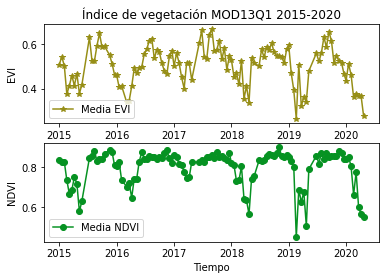

In [8]:
# Tiempo
time = EVI_serie.index # igual para el NDVI

plt.figure()

# Serie de tiempo del EVI
plt.subplot(211)
plt.plot(time, EVI_serie,label='Media EVI',color='#968E16', marker='*')
plt.title('Índice de vegetación MOD13Q1 2015-2020')
plt.xlabel('Tiempo')
plt.ylabel('EVI')
plt.legend(loc='lower left')

# Serie de tiempo del NDVI
plt.subplot(212)
plt.plot(time, NDVI_serie,label='Media NDVI',color='#069222', marker='o')
plt.xlabel('Tiempo')
plt.ylabel('NDVI')
plt.legend(loc='lower left')

plt.show()